In [1]:
# ============================================
# 0. Imports and global settings
# ============================================
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

np.random.seed(42)

pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", "{:,.4f}".format)


In [2]:
# ============================================
# 1. Load Kaggle House Prices data
# ============================================
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

train_df.head()


Train shape: (1460, 81)
Test shape : (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.0000",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.0000",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.0000",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.0000",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.0000",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


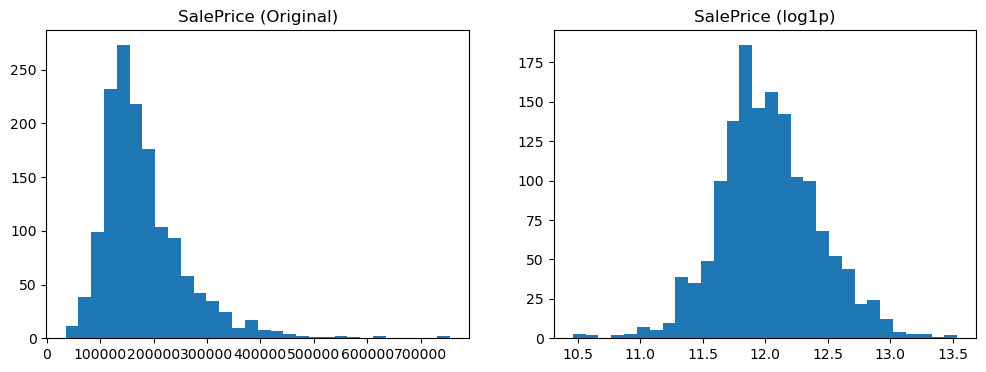

In [3]:
# ============================================
# 2. Target transformation
# ============================================
target = "SalePrice"

y = train_df[target]
y_log = np.log1p(y)
X = train_df.drop(columns=[target])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(y, bins=30)
ax[0].set_title("SalePrice (Original)")

ax[1].hist(y_log, bins=30)
ax[1].set_title("SalePrice (log1p)")
plt.show()


In [4]:
# ============================================
# 3. Identify numeric & categorical features
# ============================================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

missing_pct = train_df.isnull().mean().sort_values(ascending=False)
missing_pct[missing_pct > 0].head(20)


Numeric features: 37
Categorical features: 43


PoolQC         0.9952
MiscFeature    0.9630
Alley          0.9377
Fence          0.8075
MasVnrType     0.5973
FireplaceQu    0.4726
LotFrontage    0.1774
GarageYrBlt    0.0555
GarageCond     0.0555
GarageType     0.0555
GarageFinish   0.0555
GarageQual     0.0555
BsmtFinType2   0.0260
BsmtExposure   0.0260
BsmtQual       0.0253
BsmtCond       0.0253
BsmtFinType1   0.0253
MasVnrArea     0.0055
Electrical     0.0007
dtype: float64

In [5]:
# ============================================
# 4. Preprocessing
# ============================================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [6]:
# ============================================
# 5. Train/validation split
# ============================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y_log, test_size=0.2, random_state=42, shuffle=True
)

X_train.shape, X_val.shape


((1168, 80), (292, 80))

In [7]:
# ============================================
# 6. Linear Regression Pipeline
# ============================================
linreg_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("linreg", LinearRegression())
])


In [8]:
# ============================================
# 7. Train Linear Regression
# ============================================
linreg_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Id', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'Lo...
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])])),
                ('linreg', LinearRegression())])

In [9]:
# ============================================
# 8. Evaluation on validation set
# ============================================
y_val_pred_log = linreg_pipe.predict(X_val)

y_val_true = np.expm1(y_val.values)
y_val_pred = np.expm1(y_val_pred_log)

# Metrics
mse  = mean_squared_error(y_val_true, y_val_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val_true, y_val_pred)
r2   = r2_score(y_val_true, y_val_pred)


n = len(y_val_true)
p = linreg_pipe.named_steps["preprocessor"].transform(X_train).shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("===============================================")
print(" Linear Regression Performance (Validation) ")
print("===============================================")
print(f"MSE   : {mse:,.4f}")
print(f"RMSE  : {rmse:,.4f}")
print(f"MAE   : {mae:,.4f}")
print(f"R²    : {r2:,.4f}")
print(f"Adj R²: {adj_r2:,.4f}")   


 Linear Regression Performance (Validation) 
MSE   : 517,341,932.7504
RMSE  : 22,745.1519
MAE   : 14,894.6238
R²    : 0.9326
Adj R²: -2.9254


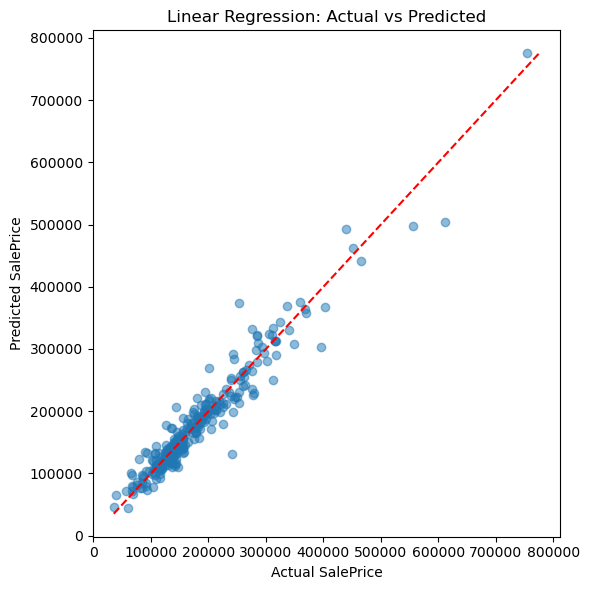

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(y_val_true, y_val_pred, alpha=0.5)
min_val = min(y_val_true.min(), y_val_pred.min())
max_val = max(y_val_true.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Linear Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()


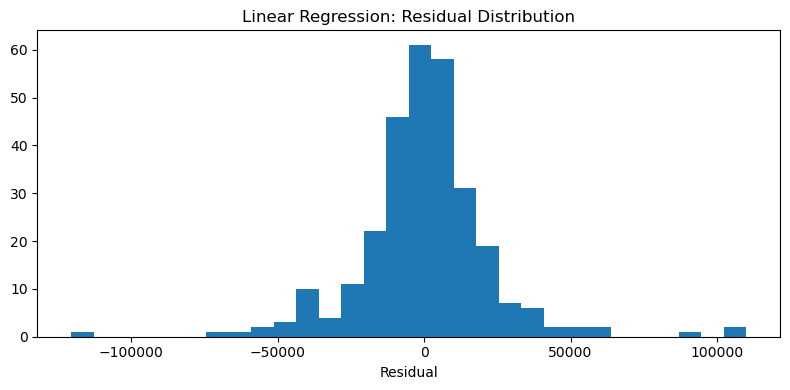

In [11]:
residuals = y_val_true - y_val_pred

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30)
plt.xlabel("Residual")
plt.title("Linear Regression: Residual Distribution")
plt.tight_layout()
plt.show()


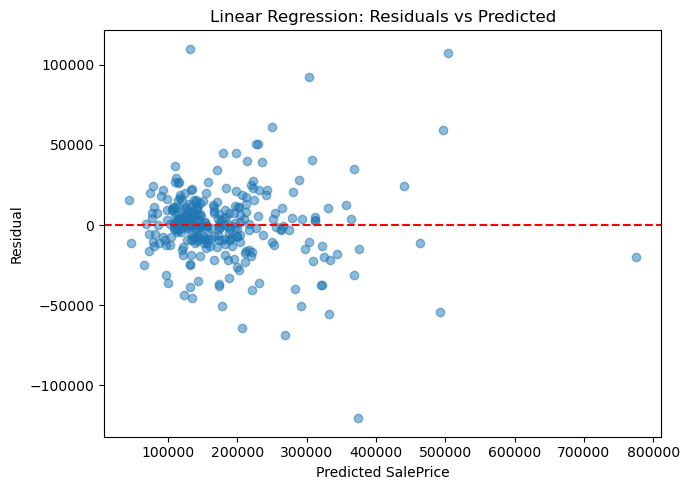

In [12]:
plt.figure(figsize=(7,5))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual")
plt.title("Linear Regression: Residuals vs Predicted")
plt.tight_layout()
plt.show()


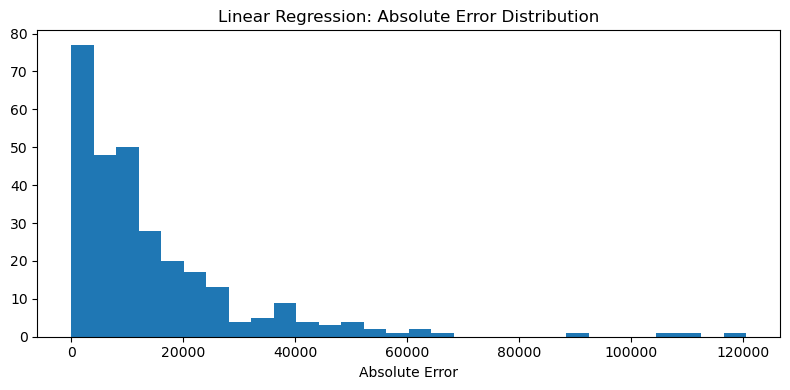

In [13]:
abs_error = np.abs(residuals)

plt.figure(figsize=(8,4))
plt.hist(abs_error, bins=30)
plt.xlabel("Absolute Error")
plt.title("Linear Regression: Absolute Error Distribution")
plt.tight_layout()
plt.show()


In [14]:
# ============================================
# 10. Final training on FULL dataset
# ============================================
final_linreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("linreg", LinearRegression())
])

final_linreg.fit(X, y_log)

print("Final Linear Regression model trained on full dataset.")


Final Linear Regression model trained on full dataset.


In [15]:
# ============================================
# 11. Evaluate FINAL Linear Regression model on validation set
# ============================================

# Re-transform validation set with full-data preprocessor
X_val_trans_full = preprocessor.transform(X_val)

# Predict (in log space)
y_val_pred_log_final = final_linreg.named_steps["linreg"].predict(X_val_trans_full)

# Convert to actual SalePrice
y_val_true_final = np.expm1(y_val.values)
y_val_pred_final = np.expm1(y_val_pred_log_final)

# Compute metrics
mse_final  = mean_squared_error(y_val_true_final, y_val_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final  = mean_absolute_error(y_val_true_final, y_val_pred_final)
r2_final   = r2_score(y_val_true_final, y_val_pred_final)

print("===============================================")
print(" Final Linear Regression Metrics (Validation) ")
print("===============================================")
print(f"MSE   : {mse_final:,.4f}")
print(f"RMSE  : {rmse_final:,.4f}")
print(f"MAE   : {mae_final:,.4f}")
print(f"R²    : {r2_final:,.4f}")


 Final Linear Regression Metrics (Validation) 
MSE   : 330,891,436.3173
RMSE  : 18,190.4216
MAE   : 11,902.6813
R²    : 0.9569
